<xarray.Dataset> Size: 3GB
Dimensions:        (time: 1320, lat: 492, lon: 594)
Coordinates:
  * time           (time) datetime64[ns] 11kB 2016-11-01 ... 2016-11-05T23:00:00
Dimensions without coordinates: lat, lon
Data variables:
    latitude       (lat, lon) float32 1MB ...
    longitude      (lat, lon) float32 1MB ...
    precipitation  (time, lat, lon) float64 3GB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Feb 05 14:07:00 2025: cdo selyear,2016 -selmonth,11 -se...
    CDO:          Climate Data Operators version 2.4.4 (https://mpimet.mpg.de...
<xarray.Dataset> Size: 2GB
Dimensions:                  (time: 720, y: 401, x: 701)
Coordinates:
    lambert_conformal_conic  float64 8B ...
    lat                      (y, x) float32 1MB ...
    lon                      (y, x) float32 1MB ...
  * time                     (time) datetime64[ns] 6kB 2016-11-01 ... 2016-11...
  * x               

/home/lar/anaconda3/envs/ara_env/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/lar/anaconda3/envs/ara_env/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/lar/anaconda3/envs/ara_env/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:498: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/home/lar/anaconda3/envs/ara_env/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/lar/anaconda3/envs/ara_env/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:524:

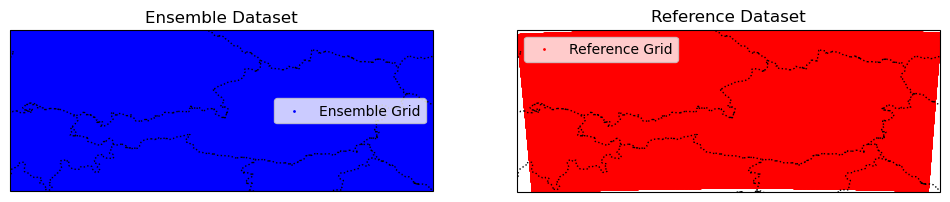

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys

sys.path.append("../scripts")  # Ensure we can import from the scripts directory
from subset_region import get_reference_extent, subset_dataset

# Load datasets
ensemble_ds = xr.open_dataset("../data/testdata_prec_201611_short.nc")
reference_ds = xr.open_dataset("../data/INCAL_HOURLY_RR_201611.nc") #SPARTACUS2-DAILY_RR_2016.nc

# Inspect the datasets
print(ensemble_ds)
print(reference_ds)

# Get reference dataset bounds
ref_bounds = get_reference_extent(reference_ds)
print(f"Reference dataset bounds: {ref_bounds}")

# Subset the ensemble dataset to match reference domain
ensemble_subset = subset_dataset(ensemble_ds, bounds=ref_bounds)
print(f"Subset ensemble dataset dimensions: {ensemble_subset.dims}")

# Save the subset dataset (for further testing)
ensemble_subset.to_netcdf("../data/test_subset_ensemble.nc")

# =======================
# 📌 Check if grids align
# =======================

def check_grid_alignment(ds1, ds2, lat_var1="latitude", lon_var1="longitude", lat_var2="lat", lon_var2="lon"):
    """
    Check if the latitude/longitude grids of two datasets overlap.

    Args:
        ds1 (xarray.Dataset): First dataset (e.g., ensemble dataset).
        ds2 (xarray.Dataset): Second dataset (e.g., reference dataset).
        lat_var1, lon_var1 (str): Latitude and longitude variable names in ds1.
        lat_var2, lon_var2 (str): Latitude and longitude variable names in ds2.

    Returns:
        bool: True if grids overlap, False otherwise.
    """

    # Extract min/max lat/lon from both datasets
    lat_min_1, lat_max_1 = ds1[lat_var1].min().values, ds1[lat_var1].max().values
    lon_min_1, lon_max_1 = ds1[lon_var1].min().values, ds1[lon_var1].max().values

    lat_min_2, lat_max_2 = ds2[lat_var2].min().values, ds2[lat_var2].max().values
    lon_min_2, lon_max_2 = ds2[lon_var2].min().values, ds2[lon_var2].max().values

    # Print the extracted bounds for debugging
    print(f"Dataset 1 (ensemble) lat bounds: [{lat_min_1}, {lat_max_1}], lon bounds: [{lon_min_1}, {lon_max_1}]")
    print(f"Dataset 2 (reference) lat bounds: [{lat_min_2}, {lat_max_2}], lon bounds: [{lon_min_2}, {lon_max_2}]")

    # Check if lat/lon ranges overlap
    lat_overlap = (lat_min_1 <= lat_max_2) and (lat_max_1 >= lat_min_2)
    lon_overlap = (lon_min_1 <= lon_max_2) and (lon_max_1 >= lon_min_2)

    print(f"Latitude overlap: {lat_overlap}, Longitude overlap: {lon_overlap}")

    return lat_overlap and lon_overlap

grid_matches = check_grid_alignment(ensemble_subset, reference_ds)

# ============================
# 📌 Visualization of Alignment
# ============================

def plot_spatial_coverage(ds1, ds2, title1="Ensemble Dataset", title2="Reference Dataset"):
    """Plot the spatial coverage of two datasets."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

    # Plot dataset 1 (Ensemble)
    ax1 = axes[0]
    ax1.set_title(title1)
    ax1.set_extent([ds1.longitude.min(), ds1.longitude.max(), ds1.latitude.min(), ds1.latitude.max()])
    ax1.add_feature(cfeature.BORDERS, linestyle=":")
    ax1.add_feature(cfeature.COASTLINE)
    ax1.scatter(ds1.longitude, ds1.latitude, s=1, c="blue", label="Ensemble Grid")
    ax1.legend()

    # Plot dataset 2 (Reference)
    ax2 = axes[1]
    ax2.set_title(title2)
    ax2.set_extent([ds2.lon.min(), ds2.lon.max(), ds2.lat.min(), ds2.lat.max()])
    ax2.add_feature(cfeature.BORDERS, linestyle=":")
    ax2.add_feature(cfeature.COASTLINE)
    ax2.scatter(ds2.lon, ds2.lat, s=1, c="red", label="Reference Grid")
    ax2.legend()

    plt.show()

plot_spatial_coverage(ensemble_subset, reference_ds)
